## In this Jupyter Notebook we will display the results after training of the model

##### Importing the libraries

In [5]:
from monai.utils import first
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)

from monai.transforms import Activations
from monai.losses import DiceLoss

import torch
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np

##### Setting the path to the directory where the model is saved and the path to the directory where the test data is stored

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = "1"

device = torch.device('cuda:0')

# Paths to the validation set and the model
validation_path = '../data_set_group_nif/nif_files_validation'
model_path = 'post_training_best'

path_validation_volumes = glob(os.path.join(validation_path, 'images/*'))
path_validation_labels = glob(os.path.join(validation_path, 'labels/*'))

validation_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(path_validation_volumes, path_validation_labels)]

##### Plotting the metrics and losses after training

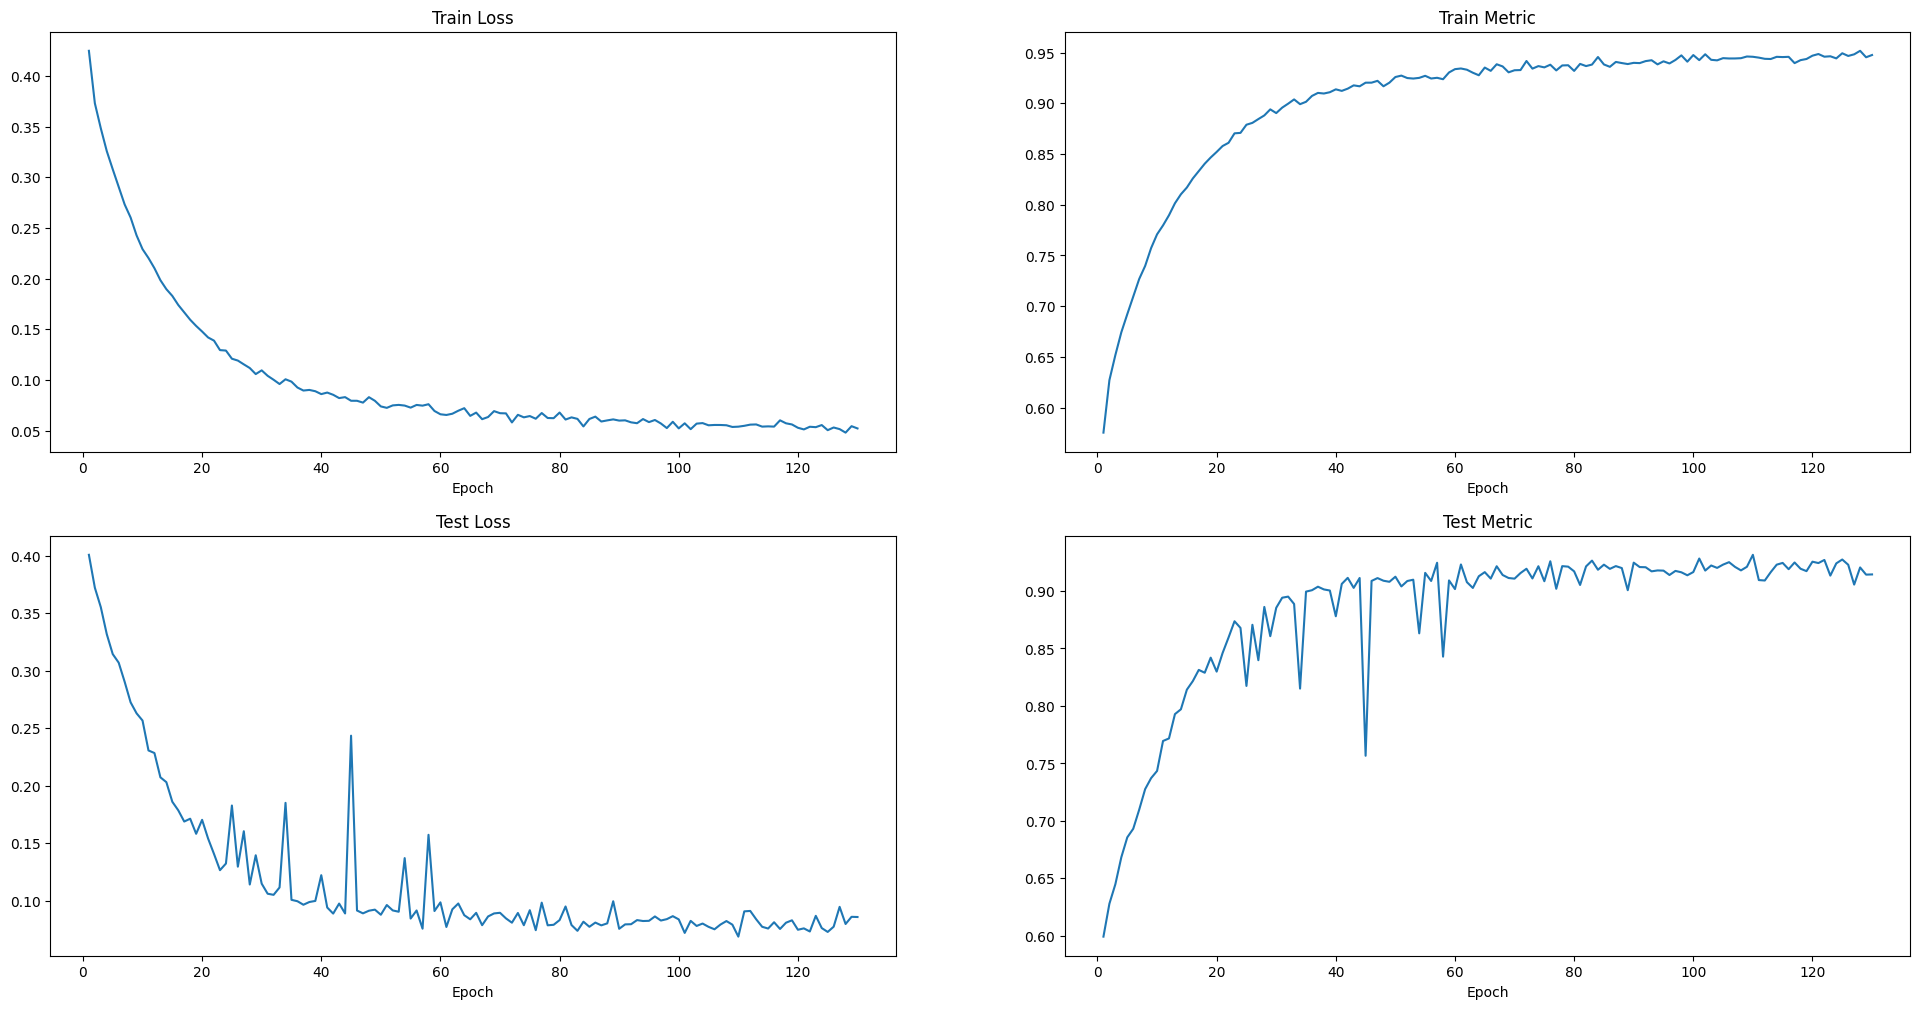

In [7]:
train_loss = np.load(os.path.join(model_path, 'train_loss.npy'))
test_loss = np.load(os.path.join(model_path, 'test_loss.npy'))

train_metric = np.load(os.path.join(model_path, 'train_metric.npy'))
test_metric = np.load(os.path.join(model_path, 'test_metric.npy'))

# Plot the loss and metric
plt.figure(figsize=(24, 12))
plt.subplot(2, 2, 1)
plt.title('Train Loss')
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel('Epoch')
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title('Train Metric')
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel('Epoch')
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title('Test Loss')
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel('Epoch')
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title('Test Metric')
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel('Epoch')
plt.plot(x, y)

#plt.savefig('metrics.png')
plt.show()

##### Aplying the transformations to the validation data

In [ ]:
# Transforms for the validation set
validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=["image", "label"], source_key='image'),
        Resized(keys=["image", "label"], spatial_size=[256,256,16]),   
        ToTensord(keys=["image", "label"]),
    ]
)

# Create the validation dataset
validation_ds = CacheDataset(data=validation_files, transform=validation_transforms)
validation_loader = DataLoader(validation_ds, batch_size=1)

##### Loading the model

In [9]:
# Load the model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load(os.path.join(model_path, 'best_metric_model.pth')))

# Set the model to evaluation mode
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


##### Inferencing on the test data

In [10]:
# Initialize some variables for the metrics
corect_negative_pixels = 0
corect_positive_pixels = 0
false_negative_pixels = 0
false_positive_pixels = 0
total_pixels = 0
total_pozitive_pixels = 0
total_negative_pixels = 0
dice_coeff = 0
IoU = 0

# Infer for all the patients of the validation set
with torch.no_grad():

    for patient in validation_loader:
        volume = patient['image'].to(device)
        label = patient['label'].to(device)
        label = label != 0

        total_pixels += label.shape[2] * label.shape[3] * label.shape[4]

        # Apply the model
        out = model(volume)

        # Calculate the Dice coefficient
        dice_loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
        dice_coeff += 1 - dice_loss(out, label).item()

        sigmoid_func = Activations(sigmoid = True)
        out = sigmoid_func(out)
        out = out > 0.5

        # Convert the tensor to numpy
        out = out.detach().cpu().numpy()
        out = out[0,1]
        #print(np.unique(out))

        label = label.detach().cpu().numpy()
        label = label[0,0]

        # Calculate the IoU
        intersection = np.sum((label != 0) & (out != 0))
        union = np.sum((label != 0) | (out != 0))
        IoU += intersection / union

        false_negative_pixels += np.sum((label != 0) & (out == 0))
        false_positive_pixels += np.sum((label == 0) & (out != 0))

        corect_negative_pixels += np.sum((label == 0) & (out == 0))
        corect_positive_pixels += np.sum((label != 0) & (out != 0))

        total_pozitive_pixels += np.sum(label != 0)
        total_negative_pixels += np.sum(label == 0)

##### Printing the model metrics

In [11]:
print(f'Accuracy: {round(((corect_negative_pixels + corect_positive_pixels)/total_pixels), 4)}')
print(f'Recall: {round((corect_positive_pixels/(corect_positive_pixels + false_negative_pixels)), 4)}')
print(f'Precision: {round((corect_positive_pixels/(corect_positive_pixels + false_positive_pixels)), 4)}')
print(f'Specificity: {round((corect_negative_pixels/(corect_negative_pixels + false_positive_pixels)), 4)}')
print(f'Sensitivity: {round((corect_positive_pixels/(corect_positive_pixels + false_negative_pixels)), 4)}')
print(f'Negative predictive value: {round((corect_negative_pixels/(corect_negative_pixels + false_negative_pixels)), 4)}')
print(f'False positive rate: {round((false_positive_pixels/(false_positive_pixels + corect_positive_pixels)), 4)}')
print(f'Youden index: {round((corect_positive_pixels/(corect_positive_pixels + false_negative_pixels)) + (corect_negative_pixels/(corect_negative_pixels + false_positive_pixels)), 4) - 1}')
print(f'F1 score: {round((2 * ((corect_positive_pixels/(corect_positive_pixels + false_positive_pixels)) * (corect_positive_pixels/(corect_positive_pixels + false_negative_pixels))))/(((corect_positive_pixels/(corect_positive_pixels + false_positive_pixels)) + (corect_positive_pixels/(corect_positive_pixels + false_negative_pixels)))), 4)}')
print(f'Error rate: {round((false_positive_pixels + false_negative_pixels)/total_pixels, 4)}')
print(f'Dice coefficient: {round(dice_coeff / len(validation_loader), 4)}')
print(f'IoU score: {round(IoU / len(validation_loader), 4)}')
print()
print(f'False negatives: {false_negative_pixels}/{total_pixels}')
print(f'False positives: {false_positive_pixels}/{total_pixels}')
print(f'Corect negatives: {corect_negative_pixels}/{total_negative_pixels}')
print(f'Corect positives: {corect_positive_pixels}/{total_pozitive_pixels}')

Accuracy: 0.9878
Recall: 0.9412
Precision: 0.9203
Specificity: 0.9922
Sensitivity: 0.9412
Negative predictive value: 0.9944
False positive rate: 0.0797
Youden index: 0.9334
F1 score: 0.9306
Error rate: 0.0122
Dice coefficient: 0.93
IoU score: 0.7808

False negatives: 1565934/306184192
False positives: 2170117/306184192
Corect negatives: 277400993/279571110
Corect positives: 25047148/26613082
